# Module 3 - Programming Assignment


## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
from typing import List, Dict, Tuple, Callable


In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("concrete_compressive_strength.csv")

In [4]:
data[0]

[222.4, 0.0, 96.7, 189.3, 4.5, 967.1, 870.3, 28.0, 24.89]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [9]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).
If you're not sure what format the output should take, refer to the course notes and what they do for that particular topic/algorithm.

## Problem 1: kNN

Implement k Nearest Neighbors with k = 9.

In [13]:
import numpy as np

<a id="distance"></a>
## distance

Simple Euclidean distance measurement as a basis for determining KNN **Used by**: [find_all_distances](#find_all_distances)

* **point1**  List[float]: Query point 
* **point2**  List[float]: Point to measure distance to
    

* **returns** float Euclidean distance

In [14]:
def distance(point1: List[float], point2: List[float])-> float:
        return np.sqrt(np.sum((np.array(point1[:7]) - np.array(point2[:7])) ** 2))

In [15]:
assert distance([3,4], [0,0]) == 5
assert distance([3,4,5], [0,0,0]) ==5*np.sqrt(2)
assert distance([3,4,5], [1,1,1]) == np.sqrt(29)

<a id="find_all_distances"></a>
## find_all_distances

Simple Euclidean distance measurement as a basis for determining KNN **Uses** [distance](#distance). **Used by**: [k_best](#k_best)

* **queryPoint** List[float]: Query point 
* **train_set** List[Float]: training fold    

* **returns** List[float]: List of distance for query point from the training set

In [16]:
def find_all_distances(queryPoint: List[float], train_set: List[List[float]])->List[float] :
        distances = [distance(queryPoint, train_x) for train_x in train_set]
        return distances

In [17]:
assert find_all_distances([0,0,0], [[3,4,5], [0,0,0], [1,1,1]]) == [5*np.sqrt(2), 0, np.sqrt(3)]
assert find_all_distances([1,1,1], [[3,4,5], [0,0,0], [1,1,1]]) == [np.sqrt(29), np.sqrt(3), 0]
assert find_all_distances([1,1,1], [[0,0,0], [0,0,0], [0,0,0]]) == [np.sqrt(3), np.sqrt(3), np.sqrt(3)]

<a id="k_best"></a>
## k_best

k best distances for a given fold **Uses** [find_all_distances](#find_all_distances). **Used by**: [knn](#knn)

* **k** int: number of nearest neighbours  
* **train_set** List[List[float]]: fold of training set

* **returns** List[float]: List y value for k neighbours

In [18]:
def k_best(k: int, list_of_distance: List[float], train_set: List[List[float]]):
        k_sorted = np.argsort(list_of_distance)[:k]
        return [train_set[i][8] for i in  k_sorted]
        

In [19]:
assert k_best(1,[5*np.sqrt(2), 0, np.sqrt(3)], [[3,4,5,0,0,0,0,0,3], [0,0,0,0,0,0,0,0,1], [1,1,1,0,0,0,0,0,2]]) ==[1]
assert k_best(2,[5*np.sqrt(2), 0, np.sqrt(3)], [[3,4,5,0,0,0,0,0,3], [0,0,0,0,0,0,0,0,1], [1,1,0,0,0,0,0,1,2]]) ==[1, 2]
assert k_best(3,[5*np.sqrt(2), 0, np.sqrt(3)], [[3,4,5,0,0,0,0,0,3], [0,0,0,0,0,0,0,0,1], [1,1,1,0,0,0,0,0,2]]) ==[1,2,3]

<a id="knn"></a>
## knn

finds Knn of a dataset using a euclidean distance measurement between a query point (test point) and a training (dataset)

* **k** int: number of nearest neighbours  
* **train_set** List[List[float]]: training set 
* **test_set**  List[List[float]]: test set

* **returns** List[float]: List y value for k neighbours

In [424]:
def knn(k: int, train_set: List[List[float]], query_point: List[float]):
    return np.mean(k_best(k, find_all_distances(query_point, train_set), train_set))
     

## Problem 2: Evaluation vs. The Mean

Using Mean Squared Error (MSE) as your evaluation metric, evaluate your implement above and the Null model, the mean.

<a id="null_model"></a>
## null_model

null model, the mean value of y in the training set **Used by**: [evaluation](#evaluation)

* **train_set** List[List[float]]: training set

* **returns** float: mean of y value from training set

In [425]:
def null_model(train_set: List[List[float]])-> List[float]:
    mean= np.sum([value[8] for value in train_set])/len(train_set)
    return mean
        

<a id="MSE"></a>
## MSE

finds Knn of a dataset using a eucliden distance measurement between a query point (test point) and a training (dataset) **Used by**: [evaluation](#evaluation)

* **result** List[float]: list of results from the model
* **test_set** List[float]: list of truth from y values

* **returns** float: MSE of model

In [426]:
def MSE(predicted, truth):
    return np.sum((np.array(predicted)-np.array(truth))**2)/len(predicted)
    

<a id="evaluation"></a>
## evaluation

finds Knn of a dataset using a eucliden distance measurement between a query point (test point) and a training (dataset) 
**Uses** [null_model](#null_model),  [MSE](#MSE). **Used by**: [ find_best_k](# find_best_k)

* **switch** int: decides which evaluation method to cover (0= knn, 1= null model, 2= for use in finding best K)

* **returns** float: MSE of model

In [427]:
def evaluation(switch: int, k: int):
    if switch == 0:
        print("Fold    train    test")
        train_mse_0 =[]
        test_mse_0 = []
        for i in range(0,10):           
            train_new, test_new = create_train_test(folds, i)
            print(i,':   {0:1.6g}'.format(MSE(knn(k, train_new, train_new), [train_y[8] for train_y in train_new])),'    {0:1.6g}'.format(MSE(knn(k, train_new, test_new), [test_y[8] for test_y in test_new])))
            train_mse_0.append(MSE(knn(k, train_new, train_new), [train_y[8] for train_y in train_new]))
            test_mse_0.append(MSE(knn(k, train_new, test_new), [test_y[8] for test_y in test_new]))
        print('-----')
        print('avg    {0:1.6g}'.format(np.mean(train_mse_0)), '{0:1.6g}'.format(np.mean(test_mse_0)))
        print('std    {0:1.6g}'.format(np.std(train_mse_0)), '{0:1.6g}'.format(np.std(test_mse_0)))
    if switch == 1:
        print("Fold    train    test")
        train_mse1 =[]
        test_mse1 = []
        for i in range(0,10):
            train_new, test_new = create_train_test(folds, i)
            print(i,':    {0:1.6g}'.format(MSE([null_model(train_new)]*len(train_new), [train_y[8] for train_y in train_new])),'    {0:1.6g}'.format(MSE([null_model(train_new)]*len(test_new), [test_y[8] for test_y in test_new])))
            train_mse1.append(MSE([null_model(train_new)]*len(train_new), [train_y[8] for train_y in train_new]))
            test_mse1.append(MSE([null_model(train_new)]*len(test_new), [test_y[8] for test_y in test_new]))
        print('-----')
        print('avg    {0:1.6g}'.format(np.mean(train_mse1)), '{0:1.6g}'.format(np.mean(test_mse1)))
        print('std    {0:1.6g}'.format(np.std(train_mse1)), '{0:1.6g}'.format(np.std(test_mse1)))  
    if switch == 2:
        train_new, test_new = create_train_test(folds, 0)
        return [MSE(knn(k, train_new, train_new), [train_y[8] for train_y in train_new]), MSE(knn(k, train_new, test_new), [test_y[8] for test_y in test_new])]
 
    

In [428]:
evaluation(1, 9)

Fold    train    test
0 :    282.949     241.793
1 :    274.889     314.157
2 :    276.222     302.206
3 :    274.249     320.372
4 :    281.777     252.146
5 :    277.101     294.255
6 :    277.405     291.512
7 :    285.049     222.905
8 :    280.203     266.426
9 :    278.106     285.332
-----
avg    278.795 279.11
std    3.39206 30.538


In [429]:
evaluation(0, 9)

Fold    train    test
0 :   90642.6     90030.3
1 :   90619.8     98914.5
2 :   89478.4     84821.5
3 :   87666.3     90157.7
4 :   91430.9     90342.9
5 :   91389.9     88720.3
6 :   88034.3     83576.7
7 :   90690     86542.6
8 :   89046.5     96717.3
9 :   89877.3     88525.7
-----
avg    89887.6 89834.9
std    1250.3 4564.02


## Problem 3: Hyperparameter Tuning

Tune the value of k.

<a id=" find_best_k"></a>
## find_best_k

performs a search over values of k to create a list of training and test results at each k 
**Uses** [evaluation](#evaluation) **Used by**: [unkown](#unknown)

* **switch** int: decides which evaluation method to cover (0= knn, 1= null model, 2= for use in finding best K)

* **returns** float: MSE of model

In [430]:
def find_best_k(lowest_k: int, highest_k: int):
    list_of_results=[]
    for i in range(lowest_k, highest_k):
        list_of_results.append(evaluation(2, i))
    return list_of_results
        

In [431]:
import matplotlib.pyplot as plt

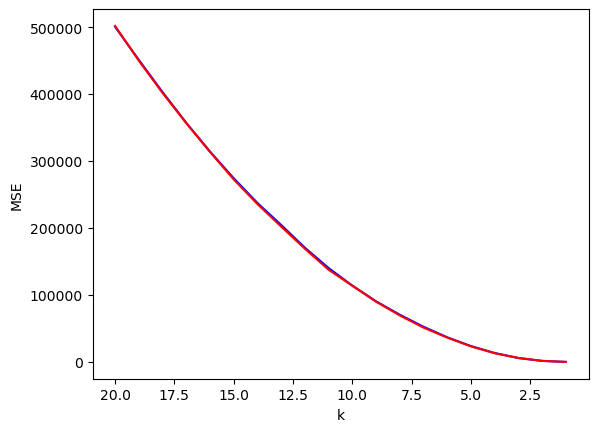

In [432]:
list_of_results =find_best_k(1, 21)
ks = list(range(1, 21))
plt.plot(ks, [result[0] for result in list_of_results], 'b', ks,[result[1] for result in list_of_results], 'r') # plots a blue line for train metrics and a red line for test metrics
plt.xlabel('k') # x-axis label
plt.ylabel('MSE') # or Average MSE # y-axis label
plt.gca().invert_xaxis()
plt.show(); # plot it but suppress any noise.

## Problem 4: Generalization Error

Analyze and discuss the generalization error of your model with the value of k from Problem 3.

Using a value of k = 2 above, I find the folling results when 10 fold cross validation is used. 
The test result show a slightly higher average and slightly higher standard deviation but the results are close to the
training result and are likely to generalize well to new X

In [436]:
# near lowest k value '2'
evaluation(0, 2)

Fold    train    test
0 :   1702.46     1772.77
1 :   1772.17     1833.2
2 :   1832.69     1811.12
3 :   1704.01     1861.67
4 :   1718.66     1849.83
5 :   1621.11     1856.93
6 :   1727.43     1811.13
7 :   1753.55     1912.74
8 :   1638.36     1863.31
9 :   1656.29     1602.44
-----
avg    1712.67 1817.51
std    60.9377 80.1862


## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

In [438]:
def standardize(train_set: List[List[float]], test_set: List[List[float]])-> (List[List[float]], List[List[float]]):
    train_array_transposed=np.array(train_set).T
    means =[]
    stds =[]
    for i in range(0,8):
        means.append(np.mean(train_arry_transposed[i]))
        stds.append(np.std(train_arry_transposed[i]))
    solution =[[]]
    solution[0] = [means[0]]*len(train_set)
        


## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.